In [18]:
from model.classification_model import ClassifierModel # class with classifiers
from model.reduce_model import ReduceModel # class with autoencoder

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from plot_settings import * # plot configuration 

ide_plot() #plot for github dark theme

In [19]:
# Load main dataset
dataset = pd.read_csv("main_datasets/dataset.csv", index_col=0)
target = pd.read_csv("main_datasets/target.csv", index_col=0)

In [20]:
reduce_model = ReduceModel(model="AE", layers=(1169, 500, 200, 10))
reduce_model.train(epochs=100, lr=1e-4)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:33<00:00,  3.03it/s]

Epoch 100, Train Loss: 0.006868734728371681
Epoch 100, Validation Loss: 0.006992100229994817


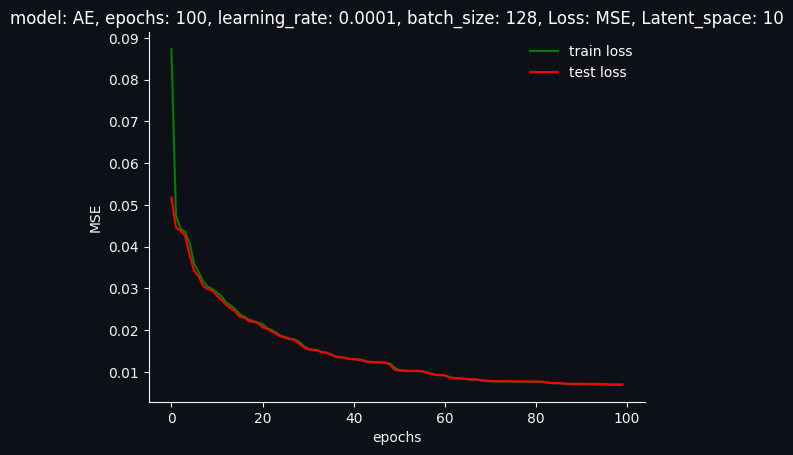

In [21]:
reduce_model.plot_loss()

In [22]:
main_reduced = reduce_model.transform(dataset)

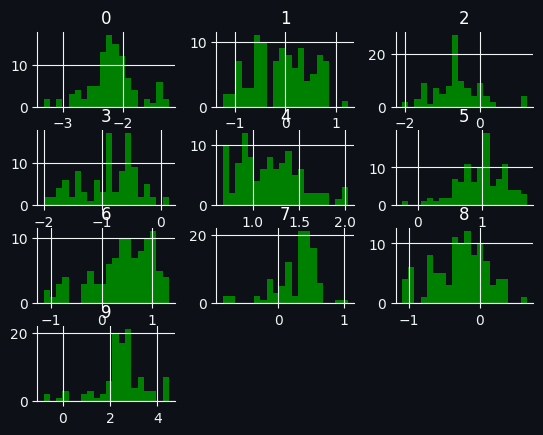

In [23]:
axes = pd.DataFrame(main_reduced).hist(bins=20)

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_2d(x1, y1, name):
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    pca = PCA(n_components=2, random_state=0)
    X_p = pca.fit_transform(x1)

    ax1.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax1.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax1.set_title(f"TSNE: {name}")

    ax2.scatter(X_p[np.where(y1 == 0), 0], X_p[np.where(y1 == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='0')
    ax2.scatter(X_p[np.where(y1 == 1), 0], X_p[np.where(y1 == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='1')
    ax2.set_title(f"PCA: {name}")
    ax2.legend()

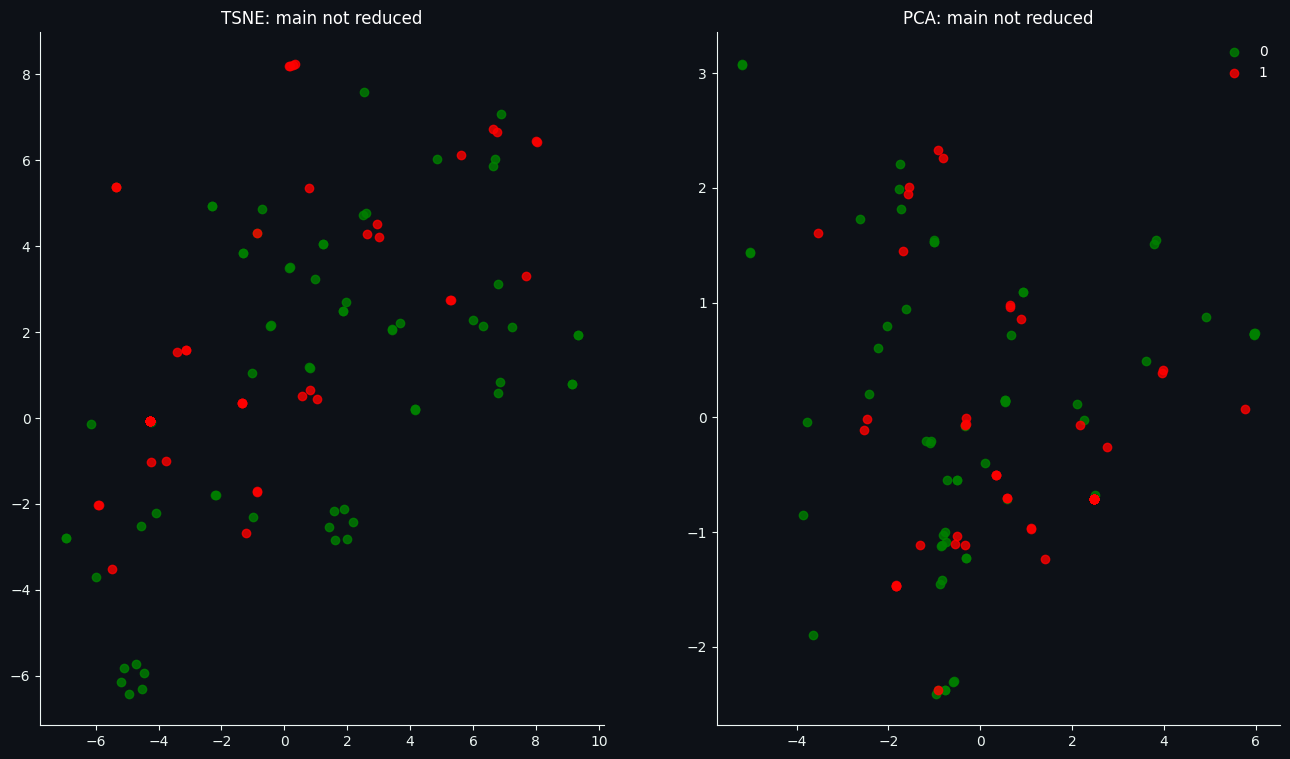

In [25]:
plot_2d(dataset, target, "main not reduced")

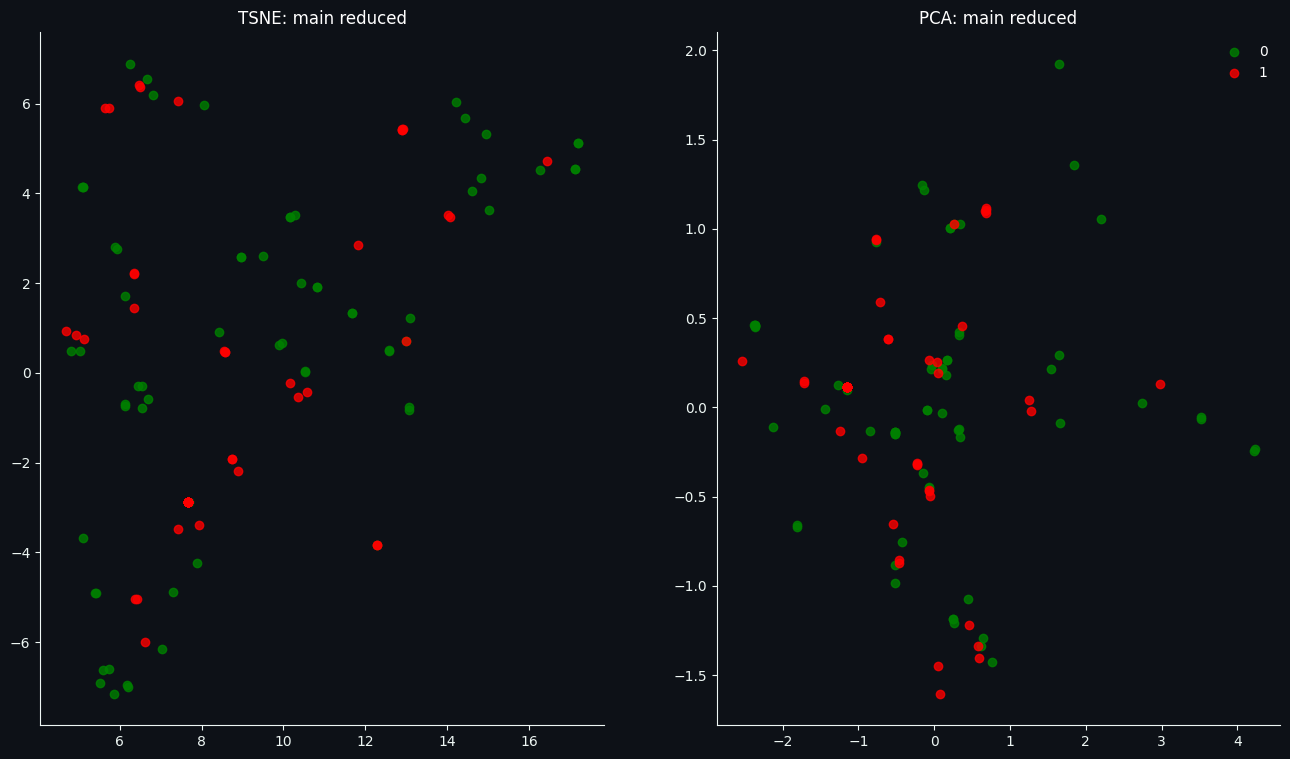

In [26]:
plot_2d(main_reduced, target, "main reduced")

# Classification

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    main_reduced, target.values.ravel(), test_size=0.2, random_state=0)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

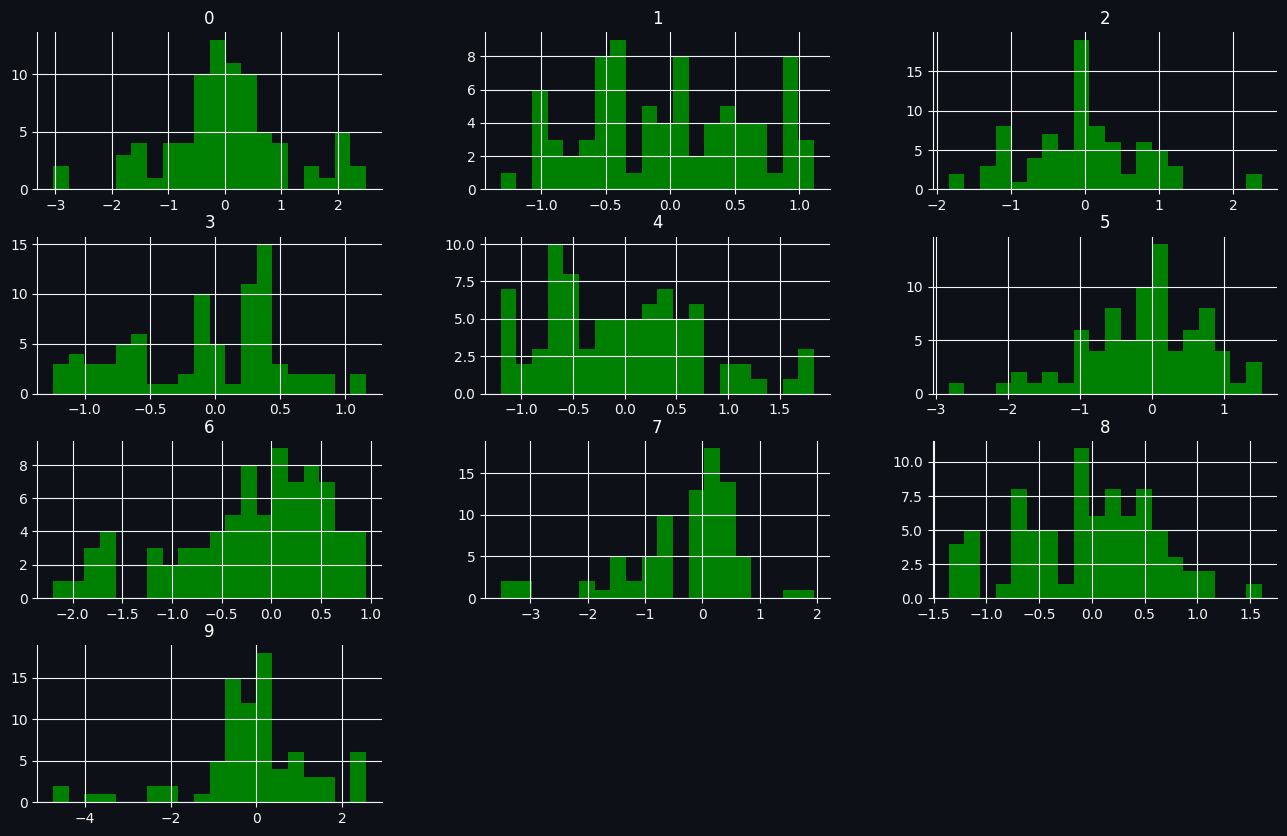

In [28]:
axes = pd.DataFrame(X_train).hist(bins=20, figsize=(16, 10))

In [29]:
c_model = ClassifierModel()
res = c_model.cv(pd.DataFrame(X_train), pd.DataFrame(y_train), time_per_clf=10)

evaluate CatBoost
  0%|          | 0/9223372036854775807 [00:00<?, ?trial/s, best loss=?]

  0%|          | 73/9223372036854775807 [00:10<352487788692745:48:48,  7.27trial/s, best loss: -0.6041666666666666]
evaluate LGM
  0%|          | 308/9223372036854775807 [00:10<83313272359114:44:16, 30.75trial/s, best loss: -0.25462962962962965]
evaluate XGB
  0%|          | 226/9223372036854775807 [00:10<113935716696827:37:36, 22.49trial/s, best loss: -0.6130952380952381]
evaluate RF
  0%|          | 73/9223372036854775807 [00:10<353907924270609:16:48,  7.24trial/s, best loss: -0.5501207729468599]
evaluate AdaBoost
  0%|          | 65/9223372036854775807 [00:10<398778902656928:55:28,  6.42trial/s, best loss: -0.6681818181818182]


In [30]:
res

{'CatBoost': {'depth': 9,
  'l2_leaf_reg': 7.095715281989455,
  'learning_rate': 0.0031994230110102043,
  'n_estimators': 61,
  'score': 0.8409090909090909,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}},
 'LGM': {'learning_rate': 0.0024649019966223444,
  'max_depth': 5,
  'n_estimators': 63,
  'reg_lambda': 0.6444069498530703,
  'subsample': 0.6326179112472944,
  'score': 0.2884615384615385,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}},
 'XGB': {'learning_rate': 0.008410070044963847,
  'max_depth': 6,
  'n_estimators': 82,
  'reg_lambda': 0.39193770570699626,
  'score': 0.8088235294117647,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}},
 'RF': {'max_depth': 52,
  'n_estimators': 66,
  'score': 0.9253246753246753,
  'balance': {'test': {'0.0': 10, '1.0': 6}, 'train': {'0.0': 42, '1.0': 23}}},
 'AdaBoost': {'learning_rate': 0.009374087142416823,
  'max_depth': 2,
  'n_estimators': 62,
  'sc

In [31]:
c_model.set_params({name: {param: res[name][param] for param in res[name] if param not in (
    "balance", "score")} for name in res})
c_model.fit(X_train, y_train)

In [32]:
for name in c_model.models:
    print(f"report for {name}")
    print(metrics.classification_report(y_test, c_model.models[name].predict(X_test)))

report for CatBoost
              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86        13
         1.0       0.83      0.62      0.71         8

    accuracy                           0.81        21
   macro avg       0.82      0.77      0.79        21
weighted avg       0.81      0.81      0.80        21

report for LGM
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        13
         1.0       0.00      0.00      0.00         8

    accuracy                           0.62        21
   macro avg       0.31      0.50      0.38        21
weighted avg       0.38      0.62      0.47        21

report for XGB
              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77        13
         1.0       0.62      0.62      0.62         8

    accuracy                           0.71        21
   macro avg       0.70      0.70      0.70        21
weighted avg       0.71 

C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\droid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344

In [33]:
def roc_auc_plot(clf_model: ClassifierModel, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    for clf in clf_model.models:
        pred_proba = clf_model.models[clf].predict_proba(x_test)
        fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
        auc = metrics.auc(fpr, tpr)
        plt.plot(fpr,
                 tpr,
                 label=f"ROC curve {clf} (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

def roc_auc_plot_one(clf: object, x_test, y_test):
    plt.figure()
    lw = 2
    plt.plot()
    pred_proba = clf.predict_proba(x_test)
    fpr, tpr, threshold = metrics.roc_curve(y_test, pred_proba[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label=f"ROC curve: (area={auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()

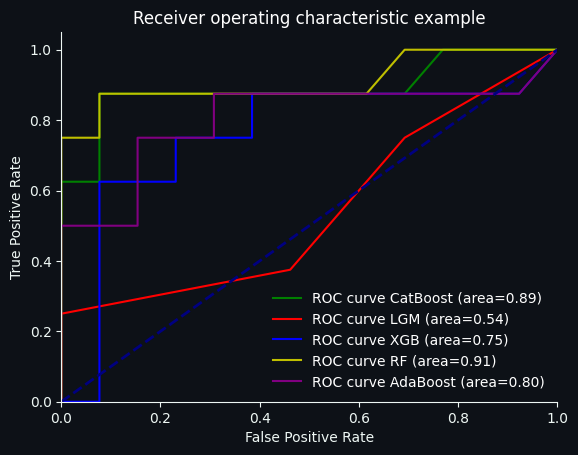

In [34]:
roc_auc_plot(c_model, X_test, y_test)